# Northwind Report: Evaluation of Employee Performance

Authors: Richard Xiao, Sandra Aziz, Matthieu Cartron

### Required Libraries

In [300]:
import sqlite3
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Introduction

The purpose of the following report and investigation is to use Northwind's Microsoft Access (tutorial) database from 2000 to investigate employee performance. This re-engineered database now exists in an SQLite database, and can be accessed using the `sqlite3` library for `python`. This data contains employee, customer, order, inventory, purchasing, supplier, and shipping data. The next step is more complex. Only data for nine employees exists in the database, and there are varying company rolls among these employees. Is there a way to compare their productivity despite these differences? Below we first begin by examining the tables, joining those we felt would, together, provide additional information. From there we delve into varying summarizations and discuss the advantages and drawbacks of various metrics. 

# Data Wrangling and Aggregation

### SQLite Connection and Testing

Before we can begin to investigate Northwind's `sqlite` database, we need to be able to read it into the JupyterLab integrated development environment. We establish a connection to the database using `sqlite3's` `.connection()` method. We subsequently establish the sql query for the table schematic (allowing us to see the names of all of the tables in the database), the connection cursor, and bring them together with the `.execute()` method. To retrieve the result of the execution, we use the `.fetchall()` on the cursor object. We subsequently close the connection with the `.close()` method.

In [247]:
con = sqlite3.connect("northwind.sqlite")

sql_query = '''
        Select name
        From sqlite_schema
        Where type = "table";
        '''
cursor = con.cursor()
cursor.execute(sql_query)
print(cursor.fetchall())
cursor.close()

[('Categories',), ('sqlite_sequence',), ('CustomerCustomerDemo',), ('CustomerDemographics',), ('Customers',), ('Employees',), ('EmployeeTerritories',), ('Order Details',), ('Orders',), ('Products',), ('Regions',), ('Shippers',), ('Suppliers',), ('Territories',)]


Below we print out all of the table names from the database schematic. We can see that the table names line up with the database diagram.  

In [248]:
pd.read_sql('''
        Select name
        From sqlite_schema
        Where type = "table";
        ''', con)

,name
0,Categories
1,sqlite_sequence
2,CustomerCustomerDemo
3,CustomerDemographics
4,Customers
5,Employees
6,EmployeeTerritories
7,Order Details
8,Orders
9,Products


Next we check to see if we can successfully return a table and its contents from the database. We try this with the `Customers` table, and call it below. 

In [249]:
pd.read_sql(''' Select * from Customers ''', con) # Connection Test

,CustomerID,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,None,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la ConstituciÃ³n 2222,MÃ©xico D.F.,None,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno TaquerÃ­a,Antonio Moreno,Owner,Mataderos 2312,MÃ©xico D.F.,None,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,None,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbkÃ¶p,Christina Berglund,Order Administrator,BerguvsvÃ¤gen 8,LuleÃ¥,None,S-958 22,Sweden,0921-12 34 65,0921-12 34 67
...,...,...,...,...,...,...,...,...,...,...,...
88,WARTH,Wartian Herkku,Pirkko Koskitalo,Accounting Manager,Torikatu 38,Oulu,None,90110,Finland,981-443655,981-443655
89,WELLI,Wellington Importadora,Paula Parente,Sales Manager,"Rua do Mercado, 12",Resende,SP,08737-363,Brazil,(14) 555-8122,None
90,WHITC,White Clover Markets,Karl Jablonski,Owner,305 - 14th Ave. S. Suite 3B,Seattle,WA,98128,USA,(206) 555-4112,(206) 555-4115
91,WILMK,Wilman Kala,Matti Karttunen,Owner/Marketing Assistant,Keskuskatu 45,Helsinki,None,21240,Finland,90-224 8858,90-224 8858


From the above result we can see that our table call was successful. Now that we know that our `SQLite` connection is functioning properly, we can begin to concatenate tables. Ideally, what we would like to do is collect as much information about the Northwind employees as possible, which will in turn give us the greatest number of options when it comes to our eventual analysis. The concatenation of tables that we can relate to our `Employees` table will form the basis of this aggregation. 

### Concatenation of Tables

First we select all of the columns from the `Employees` table and store in the object `Employees`. When we read these table in, we will be using the `read_sql()` function from pandas. 

In [250]:
Employees = pd.read_sql(''' Select * from Employees ''', con)
Employees.head(3)

,EmployeeID,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1948-12-08,1992-05-01,507 - 20th Ave. E.Apt. 2A,Seattle,WA,98122,USA,(206) 555-9857,5467,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1952-02-19,1992-08-14,908 W. Capital Way,Tacoma,WA,98401,USA,(206) 555-9482,3457,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1963-08-30,1992-04-01,722 Moss Bay Blvd.,Kirkland,WA,98033,USA,(206) 555-3412,3355,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp


We want to eventually connect employees to territories. Let's now read in the `Territories` table and store it in the object `Territories`.

In [251]:
Territories = pd.read_sql(''' Select * from Territories ''', con)
Territories.head(3)

,TerritoryID,TerritoryDescription,RegionID
0,01581,Westboro ...,1
1,01730,Bedford ...,1
2,01833,Georgetow ...,1


We also will want to eventually connect employees to regions. Let's now read in the `Regions` table and store it in the object `Regions`.

In [252]:
Regions = pd.read_sql(''' Select * from Regions ''', con)
Regions

,RegionID,RegionDescription
0,1,Eastern ...
1,2,Westerns ...
2,3,Northern ...
3,4,Southern ...


It makes sense that employee performance, given that these employees deal in sales, would be in some way tied to these orders. We should include this information when looking at employees. For now, we will read in this information and store it in the object `Orders`. 

In [253]:
Orders = pd.read_sql(''' Select * from Orders ''', con)
Orders

,OrderID,CustomerID,EmployeeID,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,1996-07-04 00:00:00.000,1996-08-01 00:00:00.000,1996-07-16 00:00:00.000,3,32.38,Vins et alcools Chevalier,59 rue de l-Abbaye,Reims,None,51100,France
1,10249,TOMSP,6,1996-07-05 00:00:00.000,1996-08-16 00:00:00.000,1996-07-10 00:00:00.000,1,11.61,Toms SpezialitÃ¤ten,Luisenstr. 48,MÃ¼nster,None,44087,Germany
2,10250,HANAR,4,1996-07-08 00:00:00.000,1996-08-05 00:00:00.000,1996-07-12 00:00:00.000,2,65.83,Hanari Carnes,"Rua do PaÃ§o, 67",Rio de Janeiro,RJ,05454-876,Brazil
3,10251,VICTE,3,1996-07-08 00:00:00.000,1996-08-05 00:00:00.000,1996-07-15 00:00:00.000,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,None,69004,France
4,10252,SUPRD,4,1996-07-09 00:00:00.000,1996-08-06 00:00:00.000,1996-07-11 00:00:00.000,2,51.30,SuprÃªmes dÃ©lices,"Boulevard Tirou, 255",Charleroi,None,B-6000,Belgium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,11073,PERIC,2,1998-05-05 00:00:00.000,1998-06-02 00:00:00.000,None,2,24.95,Pericles Comidas clÃ¡sicas,Calle Dr. Jorge Cash 321,MÃ©xico D.F.,None,5033,Mexico
826,11074,SIMOB,7,1998-05-06 00:00:00.000,1998-06-03 00:00:00.000,None,2,18.44,Simons bistro,VinbÃ¦ltet 34,Kobenhavn,None,1734,Denmark
827,11075,RICSU,8,1998-05-06 00:00:00.000,1998-06-03 00:00:00.000,None,2,6.19,Richter Supermarkt,Starenweg 5,GenÃ¨ve,None,1204,Switzerland
828,11076,BONAP,4,1998-05-06 00:00:00.000,1998-06-03 00:00:00.000,None,2,38.28,Bon app-,"12, rue des Bouchers",Marseille,None,13008,France


Next we select all columns from the `EmployeeTerritories` table so that we can connect employees and regions later on. 

In [254]:
EmployeeTerritories = pd.read_sql(''' Select * from EmployeeTerritories ''', con)
EmployeeTerritories.head()

,EmployeeID,TerritoryID
0,1,06897
1,1,19713
2,2,01581
3,2,01730
4,2,01833


Next we merge the `Employees` and `Orders` tables using the merge function from `pandas`. We use inner joins so that we retrieve rows with shared values of the 'on' argument, which in this case is the employee ID. For each of our merges we will be completing inner joins, while the 'on' argument will depend on the shared key between tables.

In [255]:
df1 = pd.DataFrame(Employees)
df2 = pd.DataFrame(Orders)

Emp_plus_Orders = df1.merge(df2, on = 'EmployeeID', how = 'inner')
Emp_plus_Orders

,EmployeeID,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,...,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,1,Davolio,Nancy,Sales Representative,Ms.,1948-12-08,1992-05-01,507 - 20th Ave. E.Apt. 2A,Seattle,WA,...,1996-08-14 00:00:00.000,1996-07-23 00:00:00.000,1,140.51,Ernst Handel,Kirchgasse 6,Graz,None,8010,Austria
1,1,Davolio,Nancy,Sales Representative,Ms.,1948-12-08,1992-05-01,507 - 20th Ave. E.Apt. 2A,Seattle,WA,...,1996-08-29 00:00:00.000,1996-08-02 00:00:00.000,1,136.54,Wartian Herkku,Torikatu 38,Oulu,None,90110,Finland
2,1,Davolio,Nancy,Sales Representative,Ms.,1948-12-08,1992-05-01,507 - 20th Ave. E.Apt. 2A,Seattle,WA,...,1996-09-04 00:00:00.000,1996-08-09 00:00:00.000,1,26.93,Magazzini Alimentari Riuniti,Via Ludovico il Moro 22,Bergamo,None,24100,Italy
3,1,Davolio,Nancy,Sales Representative,Ms.,1948-12-08,1992-05-01,507 - 20th Ave. E.Apt. 2A,Seattle,WA,...,1996-09-17 00:00:00.000,1996-08-26 00:00:00.000,2,76.83,QUICK-Stop,TaucherstraÃŸe 10,Cunewalde,None,1307,Germany
4,1,Davolio,Nancy,Sales Representative,Ms.,1948-12-08,1992-05-01,507 - 20th Ave. E.Apt. 2A,Seattle,WA,...,1996-09-25 00:00:00.000,1996-09-02 00:00:00.000,2,1.35,TradiÃ§ao Hipermercados,"Av. InÃªs de Castro, 414",Sao Paulo,SP,05634-030,Brazil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,9,Dodsworth,Anne,Sales Representative,Ms.,1966-01-27,1994-11-15,7 Houndstooth Rd.,London,None,...,1998-04-23 00:00:00.000,1998-04-23 00:00:00.000,2,32.82,Maison Dewey,Rue Joseph-Bens 532,Bruxelles,None,B-1180,Belgium
826,9,Dodsworth,Anne,Sales Representative,Ms.,1966-01-27,1994-11-15,7 Houndstooth Rd.,London,None,...,1998-05-08 00:00:00.000,1998-04-13 00:00:00.000,2,33.80,Around the Horn,Brook Farm Stratford St. Mary,Colchester,Essex,CO7 6JX,UK
827,9,Dodsworth,Anne,Sales Representative,Ms.,1966-01-27,1994-11-15,7 Houndstooth Rd.,London,None,...,1998-05-11 00:00:00.000,1998-04-20 00:00:00.000,2,754.26,Ernst Handel,Kirchgasse 6,Graz,None,8010,Austria
828,9,Dodsworth,Anne,Sales Representative,Ms.,1966-01-27,1994-11-15,7 Houndstooth Rd.,London,None,...,1998-05-12 00:00:00.000,1998-05-04 00:00:00.000,2,6.27,Hanari Carnes,"Rua do PaÃ§o, 67",Rio de Janeiro,RJ,05454-876,Brazil


We subsequently merge the `Territories` and `Regions` tables. 

In [256]:
df3 = pd.DataFrame(Territories)
df4 = pd.DataFrame(Regions)

Territories_plus_Regions = df3.merge(df4, on = 'RegionID', how = 'inner')
Territories_plus_Regions.head(10)

,TerritoryID,TerritoryDescription,RegionID,RegionDescription
0,01581,Westboro ...,1,Eastern ...
1,01730,Bedford ...,1,Eastern ...
2,01833,Georgetow ...,1,Eastern ...
3,02116,Boston ...,1,Eastern ...
4,02139,Cambridge ...,1,Eastern ...
5,02184,Braintree ...,1,Eastern ...
6,02903,Providence ...,1,Eastern ...
7,06897,Wilton ...,1,Eastern ...
8,07960,Morristown ...,1,Eastern ...
9,08837,Edison ...,1,Eastern ...


Now we merge our combined region and territories table with the employee territory table.

In [257]:
df5 = pd.DataFrame(EmployeeTerritories)
fullemployeeterritory = Territories_plus_Regions.merge(df5, on = 'TerritoryID', how = 'inner')
fullemployeeterritory.head(10)

,TerritoryID,TerritoryDescription,RegionID,RegionDescription,EmployeeID
0,01581,Westboro ...,1,Eastern ...,2
1,01730,Bedford ...,1,Eastern ...,2
2,01833,Georgetow ...,1,Eastern ...,2
3,02116,Boston ...,1,Eastern ...,2
4,02139,Cambridge ...,1,Eastern ...,2
5,02184,Braintree ...,1,Eastern ...,2
6,02903,Providence ...,1,Eastern ...,5
7,06897,Wilton ...,1,Eastern ...,1
8,07960,Morristown ...,1,Eastern ...,5
9,08837,Edison ...,1,Eastern ...,5


Below we have the region variables combined with employee and employee order data. Every row represents an order by a particular employee. 

In [258]:
EmployeeTerritories_plus_EmpID = fullemployeeterritory.merge(Emp_plus_Orders, on = "EmployeeID", how = "inner")
EmployeeTerritories_plus_EmpID.head(5)


EmployeeTerritories_plus_EmpID.head()
#EmployeeTerritories_plus_EmpID.columns

,TerritoryID,TerritoryDescription,RegionID,RegionDescription,EmployeeID,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,...,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,01581,Westboro ...,1,Eastern ...,2,Fuller,Andrew,"Vice President, Sales",Dr.,1952-02-19,...,1996-08-22 00:00:00.000,1996-08-12 00:00:00.000,1,55.28,Blondel pÃ¨re et fils,"24, place KlÃ©ber",Strasbourg,None,67000,France
1,01581,Westboro ...,1,Eastern ...,2,Fuller,Andrew,"Vice President, Sales",Dr.,1952-02-19,...,1996-09-06 00:00:00.000,1996-08-13 00:00:00.000,3,125.77,Morgenstern Gesundkost,Heerstr. 22,Leipzig,None,4179,Germany
2,01581,Westboro ...,1,Eastern ...,2,Fuller,Andrew,"Vice President, Sales",Dr.,1952-02-19,...,1996-09-11 00:00:00.000,1996-09-12 00:00:00.000,1,8.98,Berglunds snabbkÃ¶p,BerguvsvÃ¤gen Â 8,LuleÃ¥,None,S-958 22,Sweden
3,01581,Westboro ...,1,Eastern ...,2,Fuller,Andrew,"Vice President, Sales",Dr.,1952-02-19,...,1996-09-30 00:00:00.000,1996-09-10 00:00:00.000,2,1.15,Vins et alcools Chevalier,59 rue de l-Abbaye,Reims,None,51100,France
4,01581,Westboro ...,1,Eastern ...,2,Fuller,Andrew,"Vice President, Sales",Dr.,1952-02-19,...,1996-10-07 00:00:00.000,1996-09-18 00:00:00.000,2,17.68,Magazzini Alimentari Riuniti,Via Ludovico il Moro 22,Bergamo,None,24100,Italy


We want to also create an object containing the `Order Details` table because it will be what links employee, region, and order columns with product information, which contains pricing data. This will be useful in our analysis.

In [259]:
Order_details = pd.read_sql(''' Select * from 'Order Details' ''', con)
Order_details

,OrderID,ProductID,UnitPrice,Quantity,Discount
0,10248,11,14.00,12,0.00
1,10248,42,9.80,10,0.00
2,10248,72,34.80,5,0.00
3,10249,14,18.60,9,0.00
4,10249,51,42.40,40,0.00
...,...,...,...,...,...
2150,11077,64,33.25,2,0.03
2151,11077,66,17.00,1,0.00
2152,11077,73,15.00,2,0.01
2153,11077,75,7.75,4,0.00


We then merge the order details with the employee, region, and order columns,


In [260]:
EmployeeTerritories_plus_EmpID_plus_Order_details = EmployeeTerritories_plus_EmpID.merge(Order_details, on = "OrderID", how = "inner")

Below we read in the product information table and store it in the object `Products`.

In [261]:
Product_details = pd.read_sql(''' Select * from 'Products' ''', con)
Product_details

,ProductID,ProductName,SupplierID,CategoryID,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
72,73,RÃ¶d Kaviar,17,8,24 - 150 g jars,15.00,101,0,5,0
73,74,Longlife Tofu,4,7,5 kg pkg.,10.00,4,20,5,0
74,75,RhÃ¶nbrÃ¤u Klosterbier,12,1,24 - 0.5 l bottles,7.75,125,0,25,0
75,76,LakkalikÃ¶Ã¶ri,23,1,500 ml,18.00,57,0,20,0


Finally, we can merge the product information with our order, region, and employee data. The result is our final 'master' data set.

In [262]:
Aggregated_table = EmployeeTerritories_plus_EmpID_plus_Order_details.merge(Product_details, on = "ProductID", how = "inner")
Aggregated_table.columns

Index(['TerritoryID', 'TerritoryDescription', 'RegionID', 'RegionDescription',
       'EmployeeID', 'LastName', 'FirstName', 'Title', 'TitleOfCourtesy',
       'BirthDate', 'HireDate', 'Address', 'City', 'Region', 'PostalCode',
       'Country', 'HomePhone', 'Extension', 'Photo', 'Notes', 'ReportsTo',
       'PhotoPath', 'OrderID', 'CustomerID', 'OrderDate', 'RequiredDate',
       'ShippedDate', 'ShipVia', 'Freight', 'ShipName', 'ShipAddress',
       'ShipCity', 'ShipRegion', 'ShipPostalCode', 'ShipCountry', 'ProductID',
       'UnitPrice_x', 'Quantity', 'Discount', 'ProductName', 'SupplierID',
       'CategoryID', 'QuantityPerUnit', 'UnitPrice_y', 'UnitsInStock',
       'UnitsOnOrder', 'ReorderLevel', 'Discontinued'],
      dtype='object')

# Final Table: Employee Data

Below we return the columns and first few rows of our aggregated, or 'master' data set. We now want to look at those columns that might give us some insight into employee performance.

In [263]:
Aggregated_table.head()
Aggregated_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10129 entries, 0 to 10128
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TerritoryID           10129 non-null  object 
 1   TerritoryDescription  10129 non-null  object 
 2   RegionID              10129 non-null  int64  
 3   RegionDescription     10129 non-null  object 
 4   EmployeeID            10129 non-null  int64  
 5   LastName              10129 non-null  object 
 6   FirstName             10129 non-null  object 
 7   Title                 10129 non-null  object 
 8   TitleOfCourtesy       10129 non-null  object 
 9   BirthDate             10129 non-null  object 
 10  HireDate              10129 non-null  object 
 11  Address               10129 non-null  object 
 12  City                  10129 non-null  object 
 13  Region                5961 non-null   object 
 14  PostalCode            10129 non-null  object 
 15  Country            

# Analysis

Using the aggregated table we created above, we decided to analyze certain numerical variables grouped by name, employeeid, order dates and region/territory names. We want to see the differences in each demographic and employee by either product price or bulk size.

First, we wanted to take a look at the number of items each employee has. Based on these results, Robert King, Andrew Fuller and Janet Leverling have the highest number of orders, or sales. This is a good place to start, but we cannot base employee performance and productivity off of this metric. Order volume does not necessarily translate to performance; an employee with few sales may still bring in the most revenue, as the type of product sold plays an important role. If we can create a new variable, called `Revenue`, we can perhaps get a better idea as to the performance of each employee.

In [264]:
grouped_orders = Aggregated_table.groupby(['LastName', 'FirstName'])['Quantity'].size()
sorted_orders = grouped_orders.sort_values(ascending = False)
sorted_orders

LastName   FirstName
King       Robert       1760
Fuller     Andrew       1687
Leverling  Janet        1284
Peacock    Margaret     1260
Callahan   Laura        1040
Suyama     Michael       840
Buchanan   Steven        819
Dodsworth  Anne          749
Davolio    Nancy         690
Name: Quantity, dtype: int64

We first create a new table to simplify our table output in our examination of sales. Below is the indexed table, which we call `Sales`.

In [265]:
Sales = Aggregated_table.iloc[:, [3, 5, 6, 7, 13, 24, 37,38,39, 40,41,43, 45,46,47]]
Sales.head()

,RegionDescription,LastName,FirstName,Title,Region,OrderDate,Quantity,Discount,ProductName,SupplierID,CategoryID,UnitPrice_y,UnitsOnOrder,ReorderLevel,Discontinued
0,Eastern ...,Fuller,Andrew,"Vice President, Sales",WA,1996-07-25 00:00:00.000,30,0.0,Alice Mutton,7,6,39.0,0,0,1
1,Eastern ...,Fuller,Andrew,"Vice President, Sales",WA,1996-07-25 00:00:00.000,30,0.0,Alice Mutton,7,6,39.0,0,0,1
2,Eastern ...,Fuller,Andrew,"Vice President, Sales",WA,1996-07-25 00:00:00.000,30,0.0,Alice Mutton,7,6,39.0,0,0,1
3,Eastern ...,Fuller,Andrew,"Vice President, Sales",WA,1996-07-25 00:00:00.000,30,0.0,Alice Mutton,7,6,39.0,0,0,1
4,Eastern ...,Fuller,Andrew,"Vice President, Sales",WA,1996-07-25 00:00:00.000,30,0.0,Alice Mutton,7,6,39.0,0,0,1


We want to make sure that the comparisons we make in this analysis are one-to-one. For example, it would be a good idea to account for the year in which a sale was made, that way comparisons between employee are made in the same year. We will do so using the `OrderDate` column, but this format is not particularly easy to use. Instead, we create a new column, titled `Year` containing just the year of the order date. We create a function to return the first four string elements of the `OrderDate` strings, then apply this function to each row value of `OrderDate` and append it as a new column. Now it should be easy to see when an order was placed, either in 1996, 1997, or 1998. 

Note: To subset years later in our analysis, we will need have the `Year` values as numeric entries, which is why we convert them to integers below.

In [266]:
def get_year(date):
    return date[:4] 

Sales['Year'] = Sales['OrderDate'].apply(get_year)
Sales['Year'] = pd.to_numeric(Sales['Year'], errors = 'coerce')

From here we create a new variable called `Revenue`, which represents the revenue that each sale bring into the firm. This is calculated by multipling the quantity of the ordered item by the price per unit of the item. 

In [267]:
Sales.loc[:, 'Revenue'] = Sales['Quantity'] * Sales['UnitPrice_y'] 
Sales


,RegionDescription,LastName,FirstName,Title,Region,OrderDate,Quantity,Discount,ProductName,SupplierID,CategoryID,UnitPrice_y,UnitsOnOrder,ReorderLevel,Discontinued,Year,Revenue
0,Eastern ...,Fuller,Andrew,"Vice President, Sales",WA,1996-07-25 00:00:00.000,30,0.0,Alice Mutton,7,6,39.0,0,0,1,1996,1170.0
1,Eastern ...,Fuller,Andrew,"Vice President, Sales",WA,1996-07-25 00:00:00.000,30,0.0,Alice Mutton,7,6,39.0,0,0,1,1996,1170.0
2,Eastern ...,Fuller,Andrew,"Vice President, Sales",WA,1996-07-25 00:00:00.000,30,0.0,Alice Mutton,7,6,39.0,0,0,1,1996,1170.0
3,Eastern ...,Fuller,Andrew,"Vice President, Sales",WA,1996-07-25 00:00:00.000,30,0.0,Alice Mutton,7,6,39.0,0,0,1,1996,1170.0
4,Eastern ...,Fuller,Andrew,"Vice President, Sales",WA,1996-07-25 00:00:00.000,30,0.0,Alice Mutton,7,6,39.0,0,0,1,1996,1170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,Westerns ...,King,Robert,Sales Representative,None,1997-05-01 00:00:00.000,18,0.1,Gravad lax,17,8,26.0,50,25,0,1997,468.0
10125,Westerns ...,King,Robert,Sales Representative,None,1997-05-01 00:00:00.000,18,0.1,Gravad lax,17,8,26.0,50,25,0,1997,468.0
10126,Westerns ...,King,Robert,Sales Representative,None,1997-05-01 00:00:00.000,18,0.1,Gravad lax,17,8,26.0,50,25,0,1997,468.0
10127,Westerns ...,King,Robert,Sales Representative,None,1997-05-01 00:00:00.000,18,0.1,Gravad lax,17,8,26.0,50,25,0,1997,468.0


## Generated Revenue by Year

We can now look at the total revenue generated by each employee across all three years. We sort these summed revenues from highest to lowest. Based on this metric, we can see that the top three performers were Robert King, Andrew Fuller, and Margaret Peacock. This does correlate with the order volume, but narrows down the focus and pinpoints accuracy. We should consider further nuance, however. Is each employee tasked with the objective of making as many sales as possible? In the results below we also included the employee titles of each employee. It would appear reasonable to infer that 'Sales Representatives" are meant to make as many sales as possible, especially those sales that bring in the most revenue. But can the same be concluded about the Inside Sales Coordinator, Laura Callahan? Or the Sales Manager Steven Buchanan? Additionally, we should also consider that not all costs may be available to us. 

In [342]:
Revenue_Order_date = Sales.groupby(['LastName', 'FirstName', 'Title'])['Revenue'].sum()
sortedRevenue = Revenue_Order_date.sort_values(ascending = False)
sortedRevenue

LastName   FirstName  Title                   
King       Robert     Sales Representative        1516021.90
Fuller     Andrew     Vice President, Sales       1297765.84
Leverling  Janet      Sales Representative         902421.88
Peacock    Margaret   Sales Representative         825329.94
Dodsworth  Anne       Sales Representative         605966.20
Callahan   Laura      Inside Sales Coordinator     575803.44
Buchanan   Steven     Sales Manager                572220.95
Davolio    Nancy      Sales Representative         431435.58
Suyama     Michael    Sales Representative         418367.25
Name: Revenue, dtype: float64

We can get a more detailed picture of employee performance by breaking revenue down by year. We first start with 1996. In 1996, the top three performers were Robert King, Andrew Fuller and Margaret Peacock.

In [338]:
Revenue_Order_date1 = Sales.loc[Sales['Year'] == 1996].groupby(['LastName', 'FirstName', 'Title'])['Revenue'].sum()
sortedRevenue1996 = Revenue_Order_date1.sort_values(ascending = False)
sortedRevenue1996

LastName   FirstName  Title                   
King       Robert     Sales Representative        226388.00
Fuller     Andrew     Vice President, Sales       199924.90
Peacock    Margaret   Sales Representative        199267.62
Buchanan   Steven     Sales Manager               192365.60
Callahan   Laura      Inside Sales Coordinator    115871.12
Suyama     Michael    Sales Representative        110877.75
Dodsworth  Anne       Sales Representative         99538.95
Davolio    Nancy      Sales Representative         97047.56
Leverling  Janet      Sales Representative         96220.20
Name: Revenue, dtype: float64

In 1997, the top three performers were Robert King, Andrew Fuller, and Janet Leverling. 

In [270]:
Revenue_Order_date2 = Sales.loc[Sales['Year'] == 1997].groupby(['LastName', 'FirstName', 'Title'])['Revenue'].sum()
sortedRevenue1997 = Revenue_Order_date2.sort_values(ascending = False)
sortedRevenue1997

LastName   FirstName  Title                   
King       Robert     Sales Representative        724613.40
Fuller     Andrew     Vice President, Sales       538149.22
Leverling  Janet      Sales Representative        478078.12
Peacock    Margaret   Sales Representative        453277.47
Callahan   Laura      Inside Sales Coordinator    258479.88
Suyama     Michael    Sales Representative        235114.50
Buchanan   Steven     Sales Manager               232802.85
Dodsworth  Anne       Sales Representative        212282.00
Davolio    Nancy      Sales Representative        202745.76
Name: Revenue, dtype: float64

In 1998, the top three performers were Robert King, Andrew Fuller and Janet Leverling.

In [315]:
Revenue_Order_date3 = Sales.loc[Sales['Year'] == 1998].groupby(['LastName', 'FirstName', 'Title'])['Revenue'].sum()
sortedRevenue1998 = Revenue_Order_date3.sort_values(ascending = False)
sortedRevenue1998

LastName   FirstName  Title                   
King       Robert     Sales Representative        565020.50
Fuller     Andrew     Vice President, Sales       559691.72
Leverling  Janet      Sales Representative        328123.56
Dodsworth  Anne       Sales Representative        294145.25
Callahan   Laura      Inside Sales Coordinator    201452.44
Peacock    Margaret   Sales Representative        172784.85
Buchanan   Steven     Sales Manager               147052.50
Davolio    Nancy      Sales Representative        131642.26
Suyama     Michael    Sales Representative         72375.00
Name: Revenue, dtype: float64

## Line Graphs for Revenue by Year 

We decided to show some plots for how the revenue has changed by year. 1997 seems to have more revenue made by the employees wheras 1996 had the smallest revenue.

[Text(-1.0, 0, ''),
 Text(0.0, 0, ''),
 Text(1.0, 0, ''),
 Text(2.0, 0, ''),
 Text(3.0, 0, ''),
 Text(4.0, 0, ''),
 Text(5.0, 0, ''),
 Text(6.0, 0, ''),
 Text(7.0, 0, ''),
 Text(8.0, 0, ''),
 Text(9.0, 0, '')]

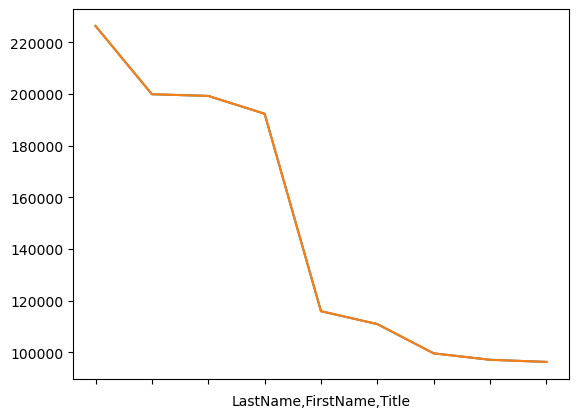

In [339]:
sortedRevenue1996.plot()
ax1996 = sortedRevenue1996.plot()
ax1996.set_xticklabels([])

[Text(-1.0, 0, ''),
 Text(0.0, 0, ''),
 Text(1.0, 0, ''),
 Text(2.0, 0, ''),
 Text(3.0, 0, ''),
 Text(4.0, 0, ''),
 Text(5.0, 0, ''),
 Text(6.0, 0, ''),
 Text(7.0, 0, ''),
 Text(8.0, 0, ''),
 Text(9.0, 0, '')]

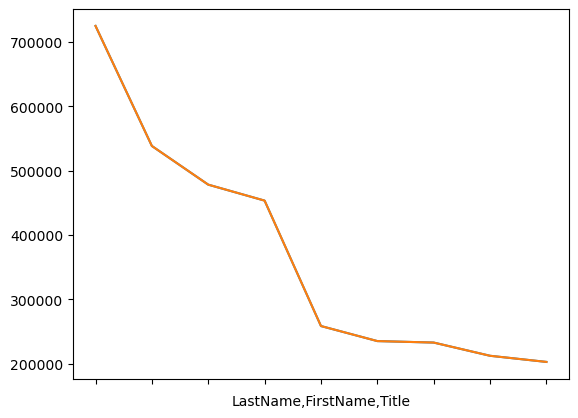

In [340]:
sortedRevenue1997.plot(x = 'Title')
ax1997 = sortedRevenue1997.plot()
ax1997.set_xticklabels([])

[Text(-1.0, 0, ''),
 Text(0.0, 0, ''),
 Text(1.0, 0, ''),
 Text(2.0, 0, ''),
 Text(3.0, 0, ''),
 Text(4.0, 0, ''),
 Text(5.0, 0, ''),
 Text(6.0, 0, ''),
 Text(7.0, 0, ''),
 Text(8.0, 0, ''),
 Text(9.0, 0, '')]

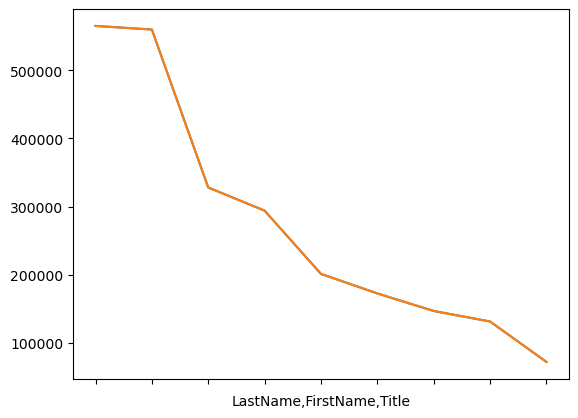

In [341]:
sortedRevenue1998.plot(x = 'Title')
ax1998 = sortedRevenue1998.plot()
ax1998.set_xticklabels([])


## Revenue by Region Description 

Next, we get a glimpse of the revenue generated by each employee broken down by region description. Each employee operated from a different region, and we can look at top performers for each region across all of the years. 

We first necessarily eliminate additional whitespace from the `RegionDescription` column, which will allow us to select for individual regions below. We create a function that strips a value of added whitespace, and subsequently use the `.apply` method to apply the function to each value of the `RegionDescription` column. 

In [272]:
def region_parse(dat):
    without_space = dat.strip()
    return without_space

Sales['RegionDescription'] = Sales['RegionDescription'].apply(region_parse)
Sales

,RegionDescription,LastName,FirstName,Title,Region,OrderDate,Quantity,Discount,ProductName,SupplierID,CategoryID,UnitPrice_y,UnitsOnOrder,ReorderLevel,Discontinued,Year,Revenue
0,Eastern,Fuller,Andrew,"Vice President, Sales",WA,1996-07-25 00:00:00.000,30,0.0,Alice Mutton,7,6,39.0,0,0,1,1996,1170.0
1,Eastern,Fuller,Andrew,"Vice President, Sales",WA,1996-07-25 00:00:00.000,30,0.0,Alice Mutton,7,6,39.0,0,0,1,1996,1170.0
2,Eastern,Fuller,Andrew,"Vice President, Sales",WA,1996-07-25 00:00:00.000,30,0.0,Alice Mutton,7,6,39.0,0,0,1,1996,1170.0
3,Eastern,Fuller,Andrew,"Vice President, Sales",WA,1996-07-25 00:00:00.000,30,0.0,Alice Mutton,7,6,39.0,0,0,1,1996,1170.0
4,Eastern,Fuller,Andrew,"Vice President, Sales",WA,1996-07-25 00:00:00.000,30,0.0,Alice Mutton,7,6,39.0,0,0,1,1996,1170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,Westerns,King,Robert,Sales Representative,None,1997-05-01 00:00:00.000,18,0.1,Gravad lax,17,8,26.0,50,25,0,1997,468.0
10125,Westerns,King,Robert,Sales Representative,None,1997-05-01 00:00:00.000,18,0.1,Gravad lax,17,8,26.0,50,25,0,1997,468.0
10126,Westerns,King,Robert,Sales Representative,None,1997-05-01 00:00:00.000,18,0.1,Gravad lax,17,8,26.0,50,25,0,1997,468.0
10127,Westerns,King,Robert,Sales Representative,None,1997-05-01 00:00:00.000,18,0.1,Gravad lax,17,8,26.0,50,25,0,1997,468.0


Next we look at the different regions to know for what strings we will need to subset.

In [273]:
Sales['RegionDescription'].unique()

array(['Eastern', 'Northern', 'Southern', 'Westerns'], dtype=object)

We first take a look at the eastern region. Across all of the years, the best performers (bringing in the most in revenue) in an eastern region was Andrew Fuller.

In [274]:
Revenue_Order_regE = Sales.loc[Sales['RegionDescription'] == 'Eastern'].groupby(['LastName', 'FirstName', 'Title'])['Revenue'].sum()
sortedRevenueEastern = Revenue_Order_regE.sort_values(ascending = False)
sortedRevenueEastern

LastName  FirstName  Title                
Fuller    Andrew     Vice President, Sales    1297765.84
Peacock   Margaret   Sales Representative      825329.94
Buchanan  Steven     Sales Manager             572220.95
Davolio   Nancy      Sales Representative      431435.58
Name: Revenue, dtype: float64

Of the employees in the western region, Robert King was the top performer. 

In [275]:
Revenue_Order_regW = Sales.loc[Sales['RegionDescription'] == 'Westerns'].groupby(['LastName', 'FirstName', 'Title'])['Revenue'].sum()
sortedRevenueWestern = Revenue_Order_regW.sort_values(ascending = False)
sortedRevenueWestern

LastName  FirstName  Title               
King      Robert     Sales Representative    1516021.90
Suyama    Michael    Sales Representative     418367.25
Name: Revenue, dtype: float64

In the northern region, Anne Dodsworth was the top performer. 

In [276]:
Revenue_Order_regN = Sales.loc[Sales['RegionDescription'] == 'Northern'].groupby(['LastName', 'FirstName', 'Title'])['Revenue'].sum()
sortedRevenueNorthern = Revenue_Order_regN.sort_values(ascending = False)
sortedRevenueNorthern

LastName   FirstName  Title                   
Dodsworth  Anne       Sales Representative        605966.20
Callahan   Laura      Inside Sales Coordinator    575803.44
Name: Revenue, dtype: float64

Only one emloyee operated from the southern region, Janet Leverling. It is worth considering if regions with fewer employees featured less competition for sales, thereby making it easier for employees with less competition to make more sales.

In [277]:
Revenue_Order_regS = Sales.loc[Sales['RegionDescription'] == 'Southern'].groupby(['LastName', 'FirstName', 'Title'])['Revenue'].sum()
sortedRevenueSouthern = Revenue_Order_regS.sort_values(ascending = False)
sortedRevenueSouthern

LastName   FirstName  Title               
Leverling  Janet      Sales Representative    902421.88
Name: Revenue, dtype: float64

## Reorder Level Analysis by Region Description

After doing a breakdown analysis on revenue, we decided to research on how the reorder levels differ from each other. Reorder levels are important to businesses because they help maximize their efficiency and could impact revenues and profits. It's a good way to for managers to focus upon certain products for the future. Like with the revenue portion, we broke down this analysis by region description to see how the reorder level thresholds are different for each product. However, instead of grouping by employee names and titles, supplierid and categoryid are used instead. 

The eastern region shows Gnocchi di nonna Alice being the highest.

In [293]:
Eastern_Product_Reorder_regE = Sales.loc[Sales['RegionDescription'] == 'Eastern'].groupby(['SupplierID', 'CategoryID','ProductName'])['ReorderLevel'].sum()
sortedRevenueEastern = Eastern_Product_Reorder_regE.sort_values(ascending = False)
sortedRevenueEastern

SupplierID  CategoryID  ProductName             
26          5           Gnocchi di nonna Alice      3240
5           4           Queso Cabrales              2790
1           1           Chang                       2375
7           1           Outback Lager               2310
25          6           PÃ¢tÃ© chinois              2220
                                                    ... 
7           8           Carnarvon Tigers               0
8           3           Sir Rodney's Marmalade         0
12          7           RÃ¶ssle Sauerkraut             0
            6           ThÃ¼ringer Rostbratwurst       0
29          3           Tarte au sucre                 0
Name: ReorderLevel, Length: 77, dtype: int64

The Western region shows that Gnocchi is once again at the top although it is significantly lower than the Eastern region. The second and third option are also different from the eastern region.

In [294]:
Westerns_Product_Reorder_regE = Sales.loc[Sales['RegionDescription'] == 'Westerns'].groupby(['SupplierID', 'CategoryID','ProductName'])['ReorderLevel'].sum()
sortedRevenueWesterns = Westerns_Product_Reorder_regE.sort_values(ascending = False)
sortedRevenueWesterns

SupplierID  CategoryID  ProductName               
26          5           Gnocchi di nonna Alice        1650
14          4           Gorgonzola Telino             1600
12          5           Wimmers gute SemmelknÃ¶del    1500
7           1           Outback Lager                 1500
5           4           Queso Cabrales                1350
                                                      ... 
7           6           Alice Mutton                     0
            8           Carnarvon Tigers                 0
11          3           GumbÃ¤r GummibÃ¤rchen            0
10          1           GuaranÃ¡ FantÃ¡stica             0
29          3           Tarte au sucre                   0
Name: ReorderLevel, Length: 75, dtype: int64

The Northern region has a completely new top 3. Values are similar to the Western region.

In [295]:
Northern_Product_Reorder_regE = Sales.loc[Sales['RegionDescription'] == 'Northern'].groupby(['SupplierID', 'CategoryID','ProductName'])['ReorderLevel'].sum()
sortedRevenueNorthern = Northern_Product_Reorder_regE.sort_values(ascending = False)
sortedRevenueNorthern

SupplierID  CategoryID  ProductName             
12          1           RhÃ¶nbrÃ¤u Klosterbier      1500
5           4           Queso Cabrales              1140
7           1           Outback Lager               1110
23          1           LakkalikÃ¶Ã¶ri               980
19          8           Boston Crab Meat             900
                                                    ... 
14          4           Mozzarella di Giovanni         0
10          1           GuaranÃ¡ FantÃ¡stica           0
12          7           RÃ¶ssle Sauerkraut             0
            6           ThÃ¼ringer Rostbratwurst       0
29          3           Tarte au sucre                 0
Name: ReorderLevel, Length: 75, dtype: int64

The Southern region has Gnocchi once again in the top 3 although the number one choice is different.

In [296]:
Southern_Product_Reorder_regE = Sales.loc[Sales['RegionDescription'] == 'Southern'].groupby(['SupplierID', 'CategoryID','ProductName'])['ReorderLevel'].sum()
sortedRevenueSouthern = Southern_Product_Reorder_regE.sort_values(ascending = False)
sortedRevenueSouthern

SupplierID  CategoryID  ProductName             
19          8           Boston Crab Meat            1200
26          5           Gnocchi di nonna Alice      1200
24          5           Filo Mix                     900
20          1           Ipoh Coffee                  800
23          1           LakkalikÃ¶Ã¶ri               720
                                                    ... 
12          6           ThÃ¼ringer Rostbratwurst       0
11          3           GumbÃ¤r GummibÃ¤rchen          0
10          1           GuaranÃ¡ FantÃ¡stica           0
8           3           Sir Rodney's Marmalade         0
29          3           Tarte au sucre                 0
Name: ReorderLevel, Length: 74, dtype: int64

It seems that based on these results, the Eastern region has the highest reorder levels among their products.

## Reorder Level Analysis by Year

Here we decided to do the reorder level analysis by the three years 1996 to 1998 to see how they differ on an annual basis and tracking any changes in products.

In [297]:
ReOrder_date = Sales.loc[Sales['Year'] == 1996].groupby(['SupplierID','CategoryID','ProductName'])['ReorderLevel'].sum()
sortedReorder1996 = ReOrder_date.sort_values(ascending = False)
sortedReorder1996

SupplierID  CategoryID  ProductName              
14          4           Gorgonzola Telino            1080
1           1           Chang                        1025
7           1           Outback Lager                 990
5           4           Queso Cabrales                990
26          5           Gnocchi di nonna Alice        900
                                                     ... 
5           4           Queso Manchego La Pastora       0
11          3           GumbÃ¤r GummibÃ¤rchen           0
6           7           Tofu                            0
7           8           Carnarvon Tigers                0
29          3           Tarte au sucre                  0
Name: ReorderLevel, Length: 74, dtype: int64

In [298]:
ReOrder_date = Sales.loc[Sales['Year'] == 1997].groupby(['SupplierID','CategoryID','ProductName'])['ReorderLevel'].sum()
sortedReorder1997 = ReOrder_date.sort_values(ascending = False)
sortedReorder1997

SupplierID  CategoryID  ProductName              
26          5           Gnocchi di nonna Alice       4320
19          8           Boston Crab Meat             3240
12          1           RhÃ¶nbrÃ¤u Klosterbier       2850
5           4           Queso Cabrales               2760
14          4           Gorgonzola Telino            2480
                                                     ... 
10          1           GuaranÃ¡ FantÃ¡stica            0
4           8           Ikura                           0
5           4           Queso Manchego La Pastora       0
14          4           Mozzarella di Giovanni          0
29          3           Tarte au sucre                  0
Name: ReorderLevel, Length: 77, dtype: int64

In [299]:
ReOrder_date = Sales.loc[Sales['Year'] == 1998].groupby(['SupplierID','CategoryID','ProductName'])['ReorderLevel'].sum()
sortedReorder1998 = ReOrder_date.sort_values(ascending = False)
sortedReorder1998

SupplierID  CategoryID  ProductName               
7           1           Outback Lager                 2310
1           1           Chang                         2125
5           4           Queso Cabrales                2010
12          5           Wimmers gute SemmelknÃ¶del    1890
            1           RhÃ¶nbrÃ¤u Klosterbier        1475
                                                      ... 
4           6           Mishi Kobe Niku                  0
15          4           Flotemysost                      0
6           7           Tofu                             0
4           8           Ikura                            0
29          3           Tarte au sucre                   0
Name: ReorderLevel, Length: 76, dtype: int64

Interestingly enough, 1997 shows a sizeable increase in the reorder levels among their products before falling in 1998. Data indicates a bit of an economic boom among these products.